<a href="https://colab.research.google.com/github/ankanghosh/classifying-clothing-images-with-a-convolutional-neural-network/blob/main/Clothing_Image_Classification_Using_A_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Clothing Images using a Convolutional Neural Network

## Introduction

The goal of this tutorial is to demonstrate training a simple Convolutional Neural Network (CNN) to classify images of clothing, like sneakers and shirts, from the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. The tutorial is based on TensorFlow's tutorials about [basic classification of clothing images](https://www.tensorflow.org/tutorials/keras/classification) and [CNN](https://www.tensorflow.org/tutorials/images/cnn).

## Setup

Import the necessary libraries and the `datasets` module so we can import the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset.

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Data and computing resources

To train the CNN in a time-efficient manner, we will use the TPUs or GPUs allotted under the free tier of Colab. However, if you do not enjoy usage restrictions, you could also consider [upgrading](https://colab.research.google.com/signup) to *Colab Pro* or go for *Pay As you Go*, as we will need to use a GPU or a TPU to process the data and to build the model.

We will be using a TPU in this work, as it is relatively cheaper than the GPUs available in the Colab environment and also because we would be leveraging TensorFlow's distributed computing capacity to optimize the training time and resources. This can be achieved by navigating as follows.
*   Go to Runtime --> Change runtime type -->
Select TPU v2-8 under Hardware accelerator.

We can always monitor the usage of the resources we have selected as follows.
*   Go to Runtime --> View resources.

**Note:** A CPU would have worked fine in this case and would train in about 16-17 minutes. Feel free to use a CPU if time is not a constraint. Using a TPU can significantly reduce the time required to experiment with model architectures (about 14 minutes in this case) or optimize training code, potentially saving several minutes in each iteration compared to using a CPU.

## Prepare and explore the data

Load, prepare, inspect, and preprocess the data.

### Load and prepare the dataset

Import and load the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset directly from TensorFlow. The dataset consists of 70,000 grayscale images across 10 categories or classes, implying this is a multi-class classification problem. Of these, 60,000 images are designated for training your model (a CNN in this case), and 10,000 images are reserved for testing and evaluating its classification accuracy - a measure of how accurately the model has learned to classify images. See sample images (by Zalando, MIT License) of individual articles of clothing at low resolution (`28x28 pixels`) below.

**Note:** The sample images have been sourced from the original TensorFlow tutorial about [basic classification of clothing images](https://www.tensorflow.org/tutorials/keras/classification), which in turn credits the images to a [work](https://github.com/zalandoresearch/fashion-mnist) by Zalando.

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
</table>

In [ ]:
# Import the Fashion MNIST dataset from TensorFlow's "datasets" module.
fashion_mnist = datasets.fashion_mnist

# Load the Fashion MNIST dataset, split into training and test sets that contain images and corresponding labels.
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


The dataset consists of the following four NumPy arrays.

* `train_images` and `train_labels`: The training data or the training set comprising the data that the model uses to learn.
* `test_images` and `test_labels`: The test data or the test set comprising the data used to test / evaluate the model.

Each image is a `28x28 pixel` NumPy array, with pixel values ranging from `0` to `255`. The labels are arrays of integers, with values ranging from `0` to `9`. Each of these values correspond to the class of clothing an image represents. Each image is mapped to a single label. See table below.

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

**NOTE:** We will use the terms "class" and "label" interchangeably in this blog post to refer to the categories of clothing images in the dataset. A “label” specifically refers to the identifier assigned to a class.

The class names are not included with the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, so consider storing them for use later.

In [ ]:
# Store the class names from the Fashion MNIST dataset for use later.
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Inspect the data

Explore the shape of the training set and confirm there are 60,000 training images - each with dimensions of `28x28 pixels`.

In [ ]:
# Explore the shape of the training set.
train_images.shape

(60000, 28, 28)

Confirm there are 60,000 labels in the training set.

In [ ]:
# Get the total number of labels in the training set.
len(train_labels)

60000

Investigate the labels in the training set.

In [ ]:
# Investigate the labels in the training set.
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Notice that each label in the training set is a value between `0` and `9`. Next, explore the shape of the test set and confirm there are 10,000 test images. The dimensions of the test images would again be `28x28 pixels`.

In [ ]:
# Explore the shape of the test set.
test_images.shape

(10000, 28, 28)

Confirm there are 10,000 labels in the test set.

In [ ]:
# Get the total number of labels in the test set.
len(test_labels)

10000

### Preprocess the data

The data needs to be preprocessed before training the model. Start by inspecting the pixel values in the first image from the training set. The values are in the range `0` to `255`.

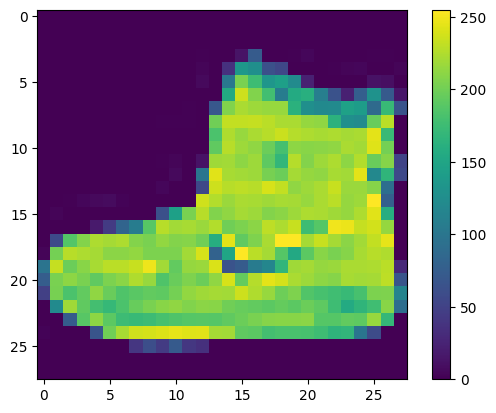

In [ ]:
# Inspect the pixel values in the first image from the training set.
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Normalize the pixel values of the images in the training and test sets to a range of `0` to `1` before feeding them into the model. The training and test sets must be preprocessed in the exact same way.

In [ ]:
# Normalize the pixel values of the images in the training set to be between "0" and "1".
train_images = train_images / 255.0

# Normalize the pixel values of the images in the test set to be between "0" and "1".
test_images = test_images / 255.0

To verify that the data is in the correct format, display the first 25 images from the training set along with their corresponding class names.

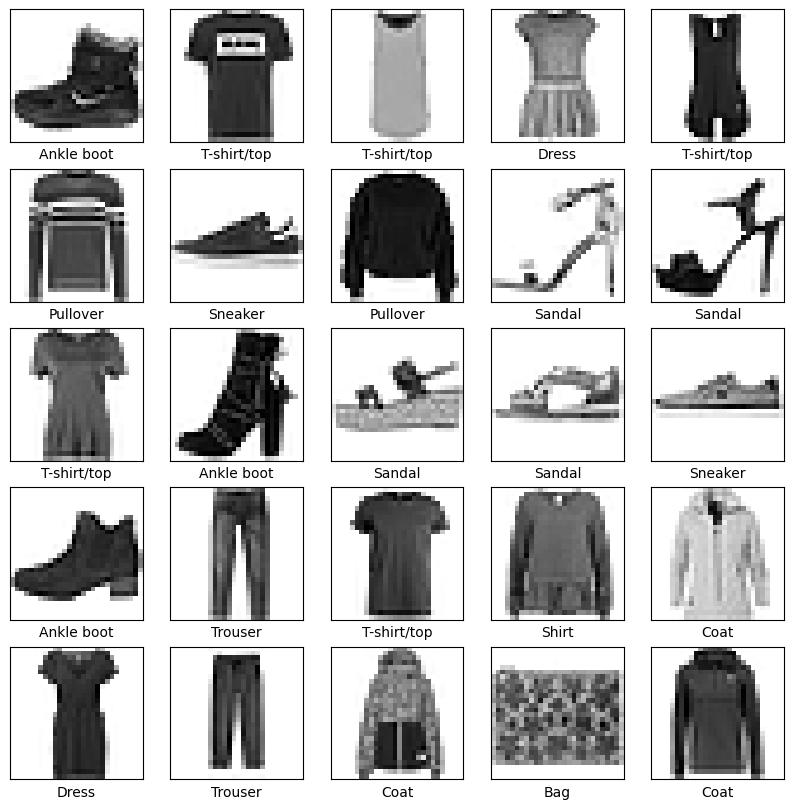

In [ ]:
# Display the first 25 images from the training set along with their corresponding class names.
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build and train the model

Build and train a model — specifically, a CNN, to classify clothing images using the preprocessed data. Start with defining the batch size for training and testing.

In [ ]:
# Define the batch size for training, validation, and testing.
batch_size = 256

### Distributed training and parallelization

As indicated earlier, we would leverage TensorFlow's distributed computing framework to optimize the use of computational resources and to minimize the time and cost required to train our model. Go ahead and set up TensorFlow to leverage TPU resources for distributed training.

The `TPUClusterResolver` connects to the TPU system, initializes it, and verifies that the TPU resources are ready and properly configured before starting the training process.

In [ ]:
# Initialize the TPU cluster resolver to connect to the TPU system.
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()

# Connect to the TPU cluster using the resolver.
tf.config.experimental_connect_to_cluster(resolver)

# Initialize the TPU system to prepare it for training.
tf.tpu.experimental.initialize_tpu_system(resolver)

Define a strategy to distribute the training across TPU cores, aiming to accelerate and optimize the training process. It is worth noting that in this particular case, distributed computing using the `TPUStrategy` reduces the training time by a factor of tens, as compared to the time required to train the model without implementing parallelization.

In [ ]:
# Step 2: Define the distribution strategy to distribute the training across the TPU cores.
strategy = tf.distribute.TPUStrategy(resolver)

### Define the convolutional base

A CNN is a type of deep learning model designed to process and classify visual data like images by automatically learning hierarchical features from input images. It consists of several key layers shown below.

1.   **Convolutional Layers:** These layers apply convolution operations to the input, using filters (kernels) to detect local patterns such as edges, textures, and simple shapes. Each filter slides over the input image, computing dot products to produce feature maps that highlight specific features.
2.   **Activation Function:** After convolution, the Rectified Linear Unit (ReLU) activation function is applied to the convolved feature map to introduce non-linearity into the model, enabling it to learn complex patterns. ReLU replaces negative pixel values in the feature map with zero, maintaining positive values unchanged.
2.   **Pooling Layers:** Pooling layers reduce the spatial dimensions of feature maps, retaining the most important information while decreasing computational load. Max pooling, for instance, selects the maximum value within a defined window, effectively downsampling the feature map.
2.   **Fully Connected (Dense) Layers:** In the final stages, fully connected layers interpret the high-level features extracted by previous layers to make predictions. These layers connect every neuron from the preceding layer to each neuron in the current layer, culminating in an output layer that provides classification probabilities across different categories.

By integrating the aforementioned layers, CNNs can effectively learn and recognize intricate patterns in images, making them highly proficient in tasks like image classification and object detection. For a more detailed explanation, refer to [this](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks) article about CNNs by Google.

Go ahead and define the convolutional base using the common pattern introduced earlier: a stack of convolutional (`tf.keras.layers.Conv2D`) and max pooling (`tf.keras.layers.MaxPooling2D`) layers. A CNN takes tensors of shape `(image_height, image_width, color_channels)` as input, ignoring the batch size. `color_channels` refers to the channel values `(R, G, B)`. The CNN needs to be configured according to the shape of the input Fashion MNIST images, which is `(28, 28, 1)`. This is achieved by passing the argument `input_shape` to the first `Conv2D` layer.


### Add dense layers

To perform classification, feed the last output tensor from the convolutional base into one or more `tf.keras.layers.Dense` layers. These are densely connected or fully connected neural layers that take One-Dimensional (1D) vectors as input, while the output of the convolutional base is a Three-Dimensional (3D) tensor. To solve for this, flatten (or unroll) the 3D output to a 1D vector using the `tf.keras.layers.Flatten` layer. This layer is responsible for unstacking the rows from the output of the convolutional base and flattening them into a single line of data. The `Flatten` layer has no parameters (weights and biases) to learn and is only responsible for reformatting the data.

Next, add a `Dense` layer on top of the `Flatten` layer. Finally, add a `Dense` layer with 10 output nodes / units / neurons. This final layer returns a logit array of length 10. Each logit corresponds to one of the 10 classes in the Fashion MNIST dataset and represents a raw, unnormalized score that indicates how likely the current image belongs to that class. Layers such as `Conv2D` and `Dense` have parameters that are learned from the input data during training, allowing the model to extract relevant features and make accurate predictions for classification.

### Compile the model

There are a few more steps that need to be completed before training the model. They are added during the model's compile step.

* **Loss Function:** Quantifies how well the model’s predictions match the true labels during training. The objective is to minimize this value to steer the model in the right direction and improve its performance. For this tutorial, we will use the `tf.keras.losses.SparseCategoricalCrossentropy()` loss function.

* **Optimizer:** Determines how the model’s parameters are updated based on the loss function and the training data. Specifically, we will use the `adam` optimizer.

* **Metrics:** Used to monitor the performance of the model during training and testing steps. This work uses the metric `accuracy`. Accuracy refers to the fraction of the images that are correctly classified.

Finally, the model will utilize the distributed training infrastructure provided by the TPU. This requires initializing and compiling the model within the scope of the TPU’s distributed training strategy - `TPUStrategy`.

In [ ]:
# Define the scope for distributed training using the specified strategy.
with strategy.scope():
    # Create a sequential model.
    model = tf.keras.Sequential([
        # Add a Two-Dimensional (2D) convolutional layer with 32 filters and a 3x3 kernel, using ReLU activation.
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        # Add a max pooling layer with a 2x2 pool size to downsample the feature maps.
        layers.MaxPooling2D((2, 2)),
        # Add a second 2D convolutional layer with 64 filters and a 3x3 kernel.
        layers.Conv2D(64, (3, 3), activation="relu"),
        # Add another max pooling layer with a 2x2 pool size.
        layers.MaxPooling2D((2, 2)),
        # Add a third 2D convolutional layer with 64 filters and a 3x3 kernel.
        layers.Conv2D(64, (3, 3), activation="relu")
    ])

    # Flatten the 2D feature maps into a 1D vector.
    model.add(layers.Flatten())
    # Add a dense (fully connected) layer with 128 units and ReLU activation.
    model.add(layers.Dense(128, activation="relu"))
    # Add the output dense layer with 10 output units (for 10 classes).
    model.add(layers.Dense(10))

    # Compile the model with the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric.
    model.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

Investigate the model's architecture.

In [ ]:
# Investigate the model's architecture.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

Investigating the summary of the model confirms that the output of every `Conv2D` and `MaxPooling2D` layer is indeed a 3D tensor of shape `(image_height, image_width, color_channels)`. The height and width dimensions decrease as you go deeper into the network. The number of output channels for each `Conv2D` layer is controlled by the first argument (e.g., `32` or `64`). As the height and width decrease, it becomes computationally feasible to increase the number of output channels in deeper `Conv2D` layers. The network summary also reveals that the last output tensor from the convolutional base of shape `(3, 3, 64)` outputs were flattened into vectors of shape `(576)` before going through two `Dense` layers.

### Train the model

**NOTE:** In general, and as a best practice, datasets are divided into separate training, validation, and test sets. However, in this work, the test dataset is used for both validation (to validate the model during training) and testing (to evaluate the model’s performance). As a result, no separate validation dataset is defined.

Define an early stopping callback. This will help stop the training once the validation loss stops improving after a certain number of epochs.

In [4]:
# Define an early stopping callback.
early_stopping = EarlyStopping(
    monitor="val_loss", # Monitor the validation loss.
    patience=3, # The number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True # Restore model weights from the epoch with the best value of the validation loss.
)

Train and fit the model.

In [ ]:
# Train and fit the model.
history = model.fit(
    train_images,          # Training data.
    train_labels,          # Training labels.
    epochs=20,             # Number of epochs (iterations over the entire dataset).
    validation_data=(test_images, test_labels),  # Validation data and labels.
    callbacks=[early_stopping],  # Early stopping callback.
    batch_size=batch_size, # Number of samples per batch.
    verbose=1              # Level of verbosity during training (1: progress bar, 0: silent, 2: one line per epoch).
)

Epoch 1/20
235/235 [==============================] - 14s 44ms/step - loss: 0.6794 - accuracy: 0.7525 - val_loss: 0.4851 - val_accuracy: 0.8219
Epoch 2/20
235/235 [==============================] - 5s 22ms/step - loss: 0.4096 - accuracy: 0.8522 - val_loss: 0.3870 - val_accuracy: 0.8608
Epoch 3/20
235/235 [==============================] - 5s 22ms/step - loss: 0.3465 - accuracy: 0.8737 - val_loss: 0.3678 - val_accuracy: 0.8612
Epoch 4/20
235/235 [==============================] - 5s 22ms/step - loss: 0.3109 - accuracy: 0.8870 - val_loss: 0.3429 - val_accuracy: 0.8793
Epoch 5/20
235/235 [==============================] - 5s 22ms/step - loss: 0.2895 - accuracy: 0.8935 - val_loss: 0.3196 - val_accuracy: 0.8812
Epoch 6/20
235/235 [==============================] - 5s 22ms/step - loss: 0.2689 - accuracy: 0.9016 - val_loss: 0.2924 - val_accuracy: 0.8943
Epoch 7/20
235/235 [==============================] - 5s 22ms/step - loss: 0.2537 - accuracy: 0.9058 - val_loss: 0.2823 - val_accuracy: 0.896

## Evaluate the model

After training, the model has learned to associate the images and the labels. In this section, we will perform the following tasks to evaluate the model.


*   Evaluate how the model performs with the test data.
*   Plot the loss and accuracy of the model with the training and validation data.
*   Have the model classify clothing images from the test dataset.
*   Plot the confusion matrix to investigate how the model performs in terms of classifying clothing images across classes.
*   Calculate the precision, recall, and F1 scores across classes.

### Performance on test data

Evaluate the model and see how it performs on the test data in terms of the loss and accuracy.

In [ ]:
# Evaluate the model in terms of the loss and accuracy on the test data.
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

# Print the loss on the test data.
print(f"Test Loss: {test_loss}")

# Print the accuracy on the test data.
print(f"Test Accuracy: {test_acc}")

313/313 - 5s - loss: 0.2515 - accuracy: 0.9140 - 5s/epoch - 16ms/step
Test Loss: 0.2515180706977844
Test Accuracy: 0.9139999747276306


### Plot the training and validation loss and accuracy

Plot the accuracy and loss of the model for the training and validation data and investigate if we are overfitting or underfitting the data. The `history` object contains information about the training process that we will leverage.

In [ ]:
# Extract the training history.
history_dict = history.history

# Explore the information about the training process available in the "history" object.
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [3]:
# Training accuracy.
acc = history_dict["accuracy"]

# Validation accuracy.
val_acc = history_dict["val_accuracy"]

# Training loss.
loss = history_dict["loss"]

# Validation loss.
val_loss = history_dict["val_loss"]

# Number of epochs used for training.
epochs = range(1, len(acc) + 1)

Plot the training and validation accuracy of the model.

In [ ]:
# Function to plot the training and validation accuracy of the model.
def plot_accuracy(history):
  # Plot the training & validation accuracy values.
  plt.figure(figsize=(12, 4))
  plt.plot(epochs, acc, label="accuracy")
  plt.plot(epochs, val_acc, label="val_accuracy")
  plt.title("Model Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(["Train", "Validation"], loc="upper left")
  plt.grid(True)
  plt.show()

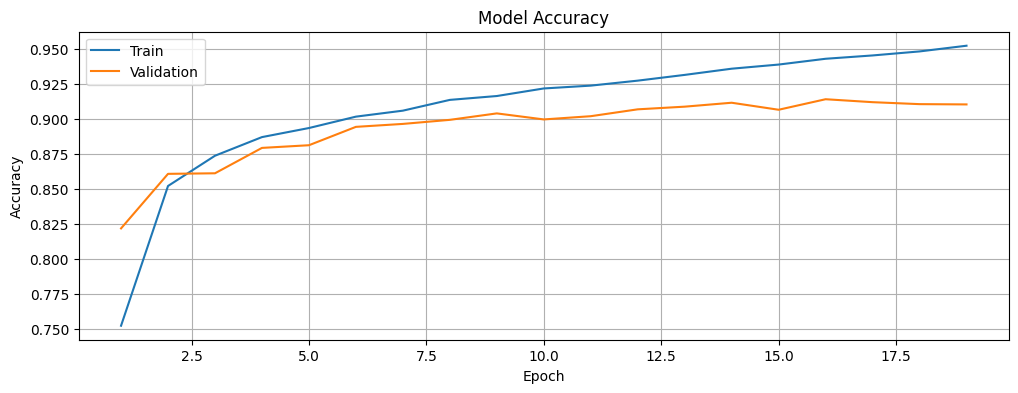

In [ ]:
# Plot the training and validation accuracy of the model.
plot_accuracy(history)

Plot the training and validation loss of the model.

In [ ]:
# Function to plot the training and validation loss of the model.
def plot_loss(history):
  # Plot the training & validation loss values.
  plt.figure(figsize=(12, 4))
  plt.plot(epochs, loss, label="loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Model Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(["Train", "Validation"], loc="upper left")
  plt.grid(True)
  plt.show()

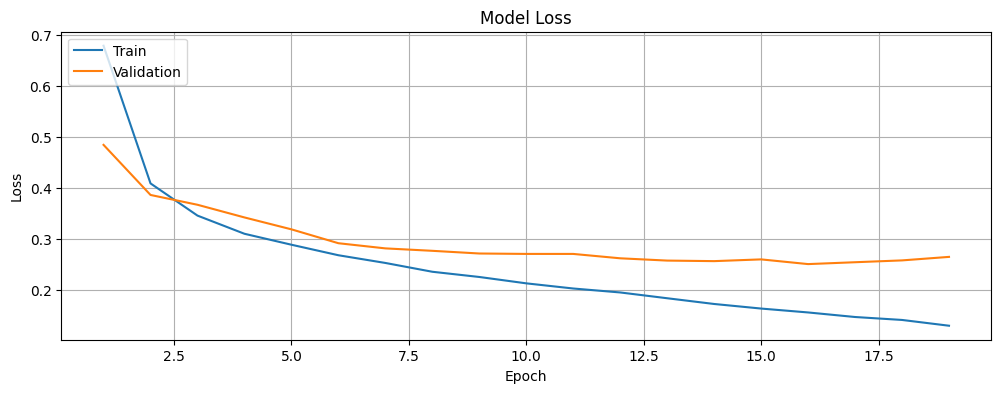

In [ ]:
# Plot the training and validation loss of the model.
plot_loss(history)

### Test the model

Use the trained model to make predictions. Attach a softmax layer to the model’s linear, raw outputs (logits) to convert them into probabilities, making the predictions easier to interpret.

In [ ]:
# Convert the logits generated by the model to probabilities for easier interpretation.
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

Have the model predict the label for each image in the test set. The predicted (or classified) label will be the class with the highest probability among the 10 classes of clothing.

In [ ]:
# Have the mode predict the label for each image in the test set.
predictions = probability_model.predict(test_images)

313/313 [==============================] - 3s 8ms/step


Review the prediction for the first image in the test set.

In [ ]:
# Review the prediction for the first image in the test set.
predictions[0]

array([1.1294762e-08, 2.7762637e-10, 2.9544156e-10, 1.2221223e-11,
       5.1011517e-10, 6.3168860e-05, 3.3061262e-10, 1.6350969e-05,
       1.9487366e-08, 9.9992043e-01], dtype=float32)

In this case, a prediction is an array of 10 values (see `predictions[0]`), each representing the model’s confidence that the image belongs to one of the 10 clothing categories. The label with the highest confidence (probability) value represents the model’s prediction or classification. See which label has the highest confidence value.

In [ ]:
# See which label has the highest confidence (predicted probability) value for the first image.
np.argmax(predictions[0])

9

The 10th label (with index `9`) has the highest confidence value. This is aligned with the values in `predictions[0]`. This implies that the model is most confident that the first image is that of an ankle boot, or `class_names[9]`. Examine the corresponding test label to confirm that this is the correct classification.

In [ ]:
# Print the test label for the first image.
test_labels[0]

9

Define functions to plot the full set of 10 class predictions.

In [ ]:
# Plot an image with its predicted and true labels.
def plot_image(i, predictions_array, true_label, img):
    # Select the true label and image for the current example.
    true_label, img = true_label[i], img[i]

    # Disable grid lines and remove ticks from x and y axes.
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Display the image using a binary colormap.
    plt.imshow(img, cmap=plt.cm.binary)

    # Identify the predicted label (class with the highest probability).
    predicted_label = np.argmax(predictions_array)

    # Set color for the predicted label: "blue" if correct, "red" if incorrect.
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"

    # Add the label with the predicted class, its confidence value, and the true class to the image.
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                color=color)

In [ ]:
# Plot a bar chart of predicted probabilities for an image.
def plot_value_array(i, predictions_array, true_label):
    # Select the true label for the current example.
    true_label = true_label[i]

    # Disable grid lines and set ticks for x-axis (class indices).
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])

    # Plot the predicted probabilities as a bar chart.
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    # Set the y-axis range from "0" to "1" (probability range).
    plt.ylim([0, 1])

    # Identify the predicted label (class with the highest probability).
    predicted_label = np.argmax(predictions_array)

    # Highlight the predicted label in red and the true label in blue.
    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")

Make a few predictions. Plot and examine the image, prediction, and prediction array. Check the prediction at index `0` (first image in the test set) in the predictions array. The correct prediction labels are `blue` and incorrect prediction labels are `red`. The number represents the model’s confidence (predicted probability) for the predicted label, expressed as a percentage. In this case, the model is `100%` confident that the image is that of an ankle boot, which is the correct prediction.

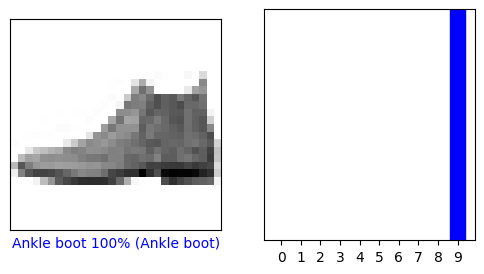

In [ ]:
# Display a single test image along with its predicted label, confidence values for each class, and the true label.
# Color correct predictions in blue and incorrect predictions in red.
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Check the prediction at index `12` (thirteenth image in the test set) in the predictions array. The model predicts that there is an `86%` chance that the image is that of a sneaker, which is the correct prediction.

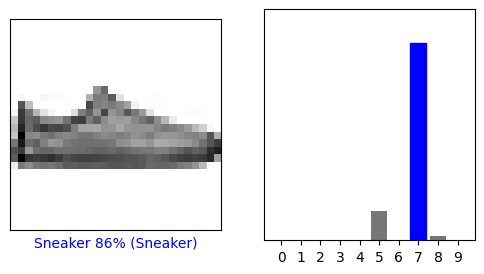

In [ ]:
# Display a single test image along with its predicted label, confidence values for each class, and the true label.
# Color correct predictions in blue and incorrect predictions in red.
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Plot several images along with their predictions. Note that the model can still be wrong, even with a high degree of confidence.

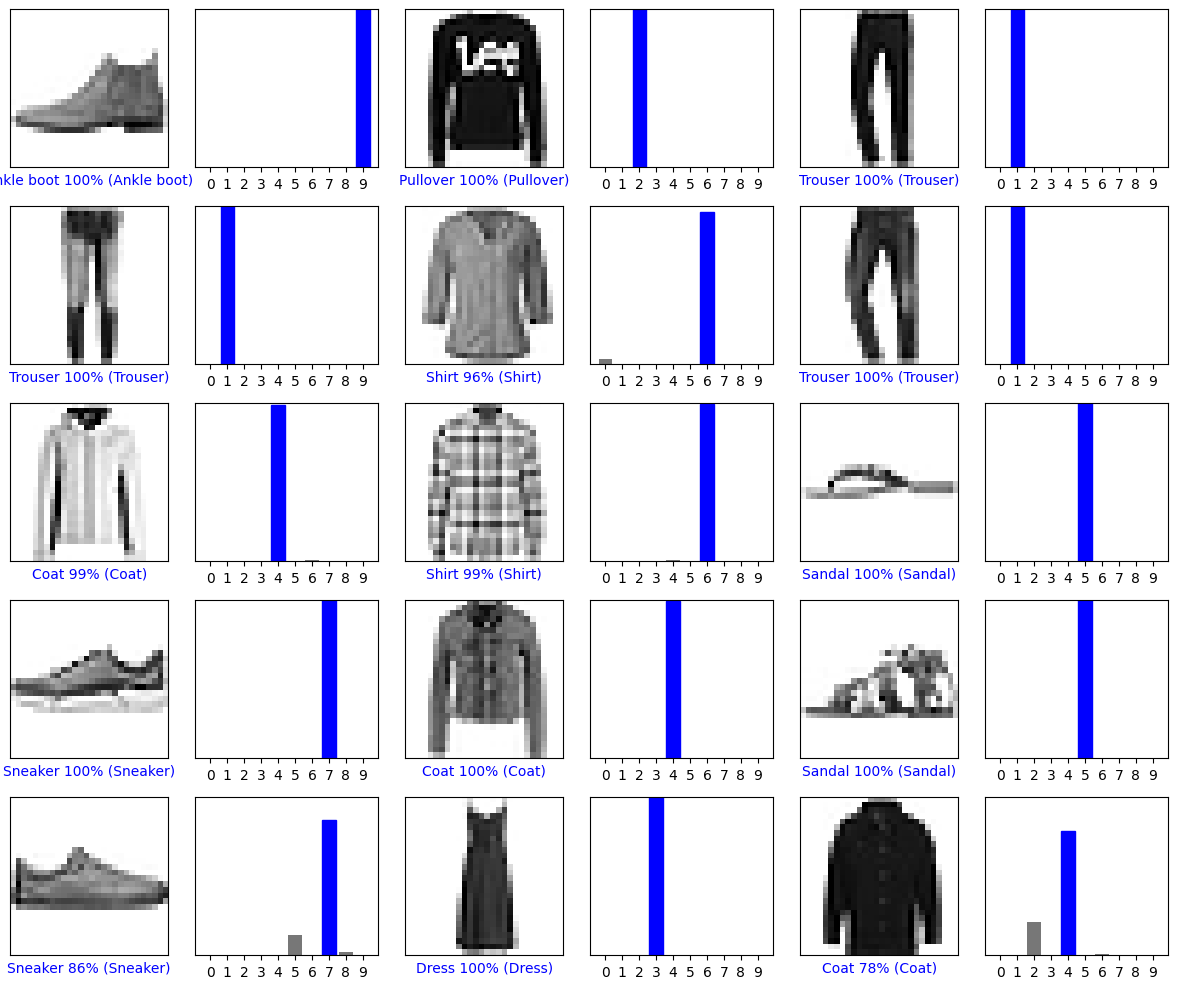

In [ ]:
# Plot the first X test images, their predicted labels, confidence values for each class, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Test the model with a single image of your choice. Go ahead and fetch an image from the test dataset and print its shape.

In [ ]:
# Fetch an image from the test dataset.
img = test_images[1]

# Print the shape of the image.
print(img.shape)

(28, 28)


`tf.keras` models are optimized to make batch predictions on collections of examples. Therefore, even a single image is required to be wrapped in a list. Add the selected image to a batch where it is the only member and print its new shape.

In [ ]:
# Add the selected image to a batch where it is the only member.
img = (np.expand_dims(img,0))

# Print the shape of the image.
print(img.shape)

(1, 28, 28)


Predict the label for the image and print the same.

In [ ]:
# Predict the label for the image.
predictions_single = probability_model.predict(img)

# Print the predicted label for the image.
print(predictions_single)

1/1 [==============================] - 0s 46ms/step
[[1.4130216e-05 5.7770256e-12 9.9998116e-01 1.1963014e-06 1.8594227e-08
  2.9887811e-12 3.4729310e-06 1.2146307e-13 2.2921203e-08 7.1863925e-11]]


Plot the predicted and true labels. In the figure below, the predicted and correct labels are the same.

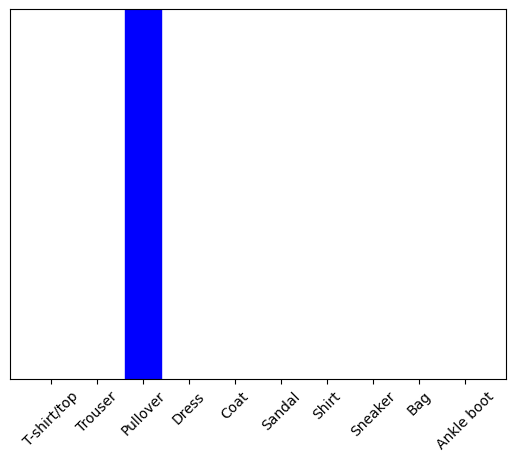

In [ ]:
# Plot the predicted probabilities for each class and highlight the true and predicted labels.
plot_value_array(1, predictions_single[0], test_labels)

# Set class names on the x-axis and rotate the labels for readability.
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict()` returns a list of lists, where each inner list corresponds to an image in the batch. Extract and review the prediction for our single image in the batch.

In [ ]:
# Get the index of the class with the highest predicted probability from the model's output.
np.argmax(predictions_single[0])

2

### Confusion matrix

Plot the confusion matrix to investigate how the model performs in terms of classifying clothing images across classes, including false positives and false negatives. To do that, convert the test predictions, which are probabilities, into predicted class labels by selecting the class with the highest probability for each image.

In [ ]:
# Convert predictions to class labels by selecting the class with the highest probability.
predicted_labels = np.argmax(predictions, axis=1)

# Confusion matrix.
cm = confusion_matrix(test_labels, predicted_labels)

Plot the confusion matrix based on the labels in the test set and the labels predicted by the model.

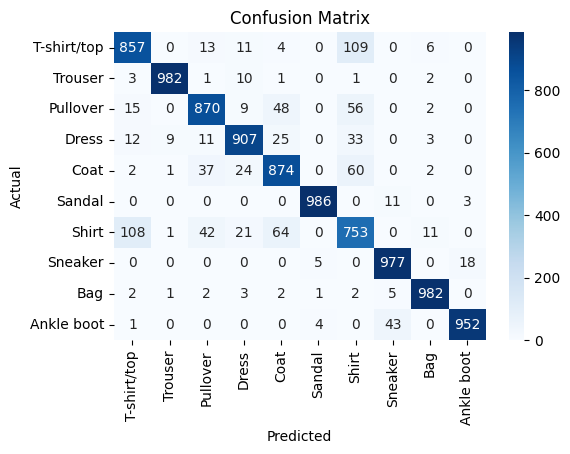

In [ ]:
# Plot the confusion matrix.
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Precision, recall, and F1 score

For additional insights, calculate the True Positives (TPs), False Positives (FPs), and False Negatives (FNs) for each class, and use them to calculate the `precision`, `recall`, and `F1 score` for each class. More on these metrics below and in [this](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall) article from TensorFlow.

*   **Precision:** Proportion of correctly predicted positive instances out of all predicted positives.
*   **Recall:** Proportion of correctly predicted positive instances out of all actual positives.
*   **F1 Score:** Harmonic mean of precision and recall, balancing both metrics.

In [ ]:
# TPs for each class are the diagonal elements.
TP = np.diagonal(cm)

# FPs for each class: Sum of each column - "TP"
FP = cm.sum(axis=0) - TP

# FNs for each class: Sum of each row - "TP"
FN = cm.sum(axis=1) - TP

# Precision for each class.
precision = TP / (TP + FP)
# Handle division by zero.
precision = np.nan_to_num(precision)

# Recall for each class.
recall = TP / (TP + FN)
# Handle division by zero.
recall = np.nan_to_num(recall)

# F1 score for each class.
F1_score = 2 * (precision * recall) / (precision + recall)
# Handle division by zero.
F1_score = np.nan_to_num(F1_score)

# Print the precision, recall, and F1 score for each class.
print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("F1 score for each class:", F1_score)

Precision for each class: [0.857      0.98792757 0.89139344 0.92081218 0.85854617 0.98995984
 0.74260355 0.94305019 0.97420635 0.97841727]
Recall for each class: [0.857 0.982 0.87  0.907 0.874 0.986 0.753 0.977 0.982 0.952]
F1 score for each class: [0.857      0.98495486 0.8805668  0.9138539  0.86620416 0.98797595
 0.74776564 0.95972495 0.97808765 0.96502788]


## Thoughts

The goal of this tutorial was to demonstrate training a basic CNN to classify images of clothing. Our CNN / model achieves a strong performance with an accuracy of about 91%. It is important to note that this is a quick and dirty implementation of a very simple CNN, and the results are not too bad based on the same.

It is also worth noting that while the training and validation loss decrease with time, the accuracy increases before stabilizing. At this stage, there is a small gap between the training and validation accuracy (around 4%), which suggests that the model is generalizing well to unseen data. While there may be slight overfitting, it is not severe enough to impact the model’s ability to classify new images accurately. This balance indicates that the model is neither underfitting nor excessively tied to the training data.

The confusion matrix reveals interesting insights. The model seems to confuse shirts, T-shirts / tops, pullovers, coats, and dresses, as well as ankle boots, sneakers, and sandals. The high precision, recall, and F1 scores across most classes confirm the robust and reliable performance of the model.  However, there is noticeable variability for the class `Shirt`, where the precision, recall, and F1 score are comparatively lower, consistent with the patterns observed in the confusion matrix.

## Next steps

Of course, there is a definite scope for improvement in this work. There are multiple ways to further develop this dirty implementation and improve the model's performance / accuracy for the classification of images of clothing. Some of those are listed below.



1.   **Modifying the Architecture:** Experiment with deeper CNNs by adding more convolutional layers, pooling layers, or fully connected layers. Introduce advanced architectures like ResNet, Inception, or MobileNet for better feature extraction.
2.   **Hyperparameter Tuning:** Optimize learning rates, batch sizes, the number of epochs, kernel sizes, and strides.
3.   **Regularization:** Add `Dropout` layers to control overfitting and consider using L2 regularization for weight penalties. Other techniques that can be used to prevent overfitting include using learning rate warmup, learning rate schedulers, and advanced techniques like label smoothing.
4.   **Data Augmentation:** Applying image-specific augmentation techniques like rotation, flipping, scaling, cropping, brightness adjustment, and random noise addition. Use libraries such as [tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), [Albumentations](https://albumentations.ai/), or [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html) to implement augmentation pipelines.
5.   **Ensemble Methods:** Using ensemble methods, such as combining predictions from multiple models can improve performance. Use techniques, such as weighted averaging, majority voting, or stacking for ensembling.
6.   **Transfer Learning with Pre-trained Models:** Fine-tune pre-trained models like [VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16), [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50), or [EfficientNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) for the dataset. Freeze lower layers and train only the top layers initially, then gradually unfreeze more layers for fine-tuning.
7.  **Fine-tuning Pre-trained Vision Transformers (ViTs):** Explore ViTs or hybrid models combining CNNs with attention mechanisms for improved performance.
8.   **Hyperparameter Optimization:** Using libraries, such as [Keras Tuner](https://keras.io/keras_tuner/) or [Optuna](https://optuna.org/) to find the best hyperparameters for the model.
9.   **Monitoring and Analysis:** Visualize feature maps from convolutional layers to understand what the model is learning. Use tools like TensorBoard or Weights & Biases for detailed training analysis.